In [1]:
# Import packages
import os
import re  # regular expressions
import warnings
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

import rioxarray as rxr

warnings.simplefilter('ignore')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'BD', 'BA_DATA'))

In [2]:
thermal_path = os.path.join("ThermalData_8day", "MOD14A2.A2000049.h08v05.006.2015041131440.hdf")

In [3]:
vege_path = os.path.join("VegeData_16day", "MOD13A2.A2000049.h08v05.006.2015136104428.hdf")

In [4]:
with rio.open(thermal_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

<open DatasetReader name='ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [5]:
# Print all of the subdatasets in the data
with rio.open(thermal_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf:MODIS_Grid_8Day_Fire:FireMask
HDF4_EOS:EOS_GRID:ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf:MODIS_Grid_8Day_Fire:QA


In [6]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(thermal_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("FireMask", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
thermal_modis = np.stack(all_bands)
thermal_modis.shape

(1, 1200, 1200)

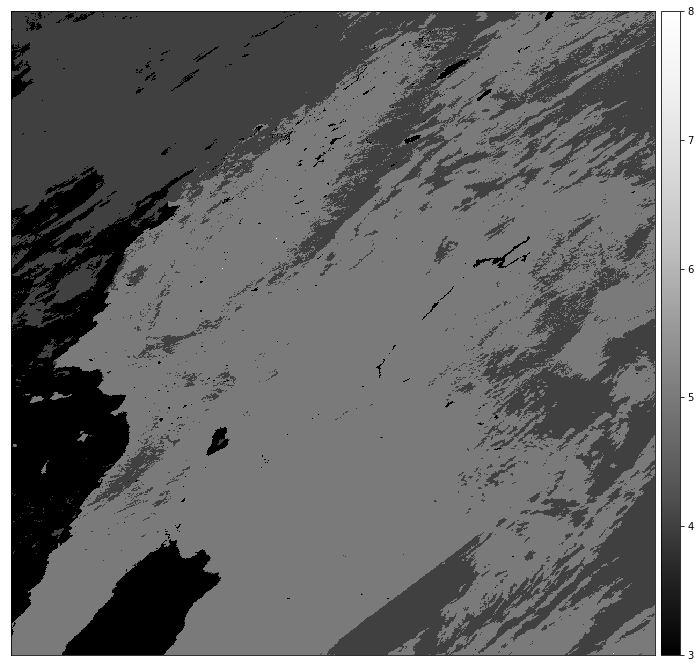

In [7]:
ep.plot_bands(thermal_modis,
              scale=False)
plt.show()

In [8]:
np.savetxt("thermalData.csv", all_bands[0], delimiter=",")

In [9]:
modis_meta

{'driver': 'HDF4Image', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1200, 'height': 1200, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'), 'transform': Affine(926.6254330558345, 0.0, -11119505.196667,
       0.0, -926.6254330558334, 4447802.078667), 'tiled': False}

In [10]:
!unpack_sds_bits -sds=QA -bit=0-1 -of=QA_bits_test.hdf ThermalData_8day/MOD14A2.A2000049.h08v05.006.2015041131440.hdf

1 QA



Processing input hdf file: ThermalData_8day/MOD14A2.A2000049.h08v05.006.2015041131440.hdf
---------------------------------------------------------------
	Processing SDS QA
Attribute _FillValue not defined for output
Done!


In [13]:
!mask_sds -of=thermal_mask_test.hdf -sds=FireMask -fill=-1 -mask="ThermalData_8day/MOD14A2.A2000049.h08v05.006.2015041131440.hdf,QA,0-1>00" ThermalData_8day/MOD14A2.A2000049.h08v05.006.2015041131440.hdf  


Processing HDF file: ThermalData_8day/MOD14A2.A2000049.h08v05.006.2015041131440.hdf
--------------------------------------------------------------------
Processing done ! 


In [ ]:
for idx in range(10):
    !mask_sds -of=thermal_masked/{idx} -sds=FireMask -fill=-1 -mask="ThermalData_8day/{idx},QA,0-1>00" ThermalData_8day/{idx}  

In [ ]:
with rio.open(vege_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

In [14]:
# Print all of the subdatasets in the data
with rio.open(vege_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days NDVI
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days relative azimuth angle
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days composite day of the year
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days pixel reliability
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days EVI
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days VI Quality
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days red reflectance
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_

In [15]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(vege_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("NDVI", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
vege_modis = np.stack(all_bands)
vege_modis.shape

(1, 1200, 1200)

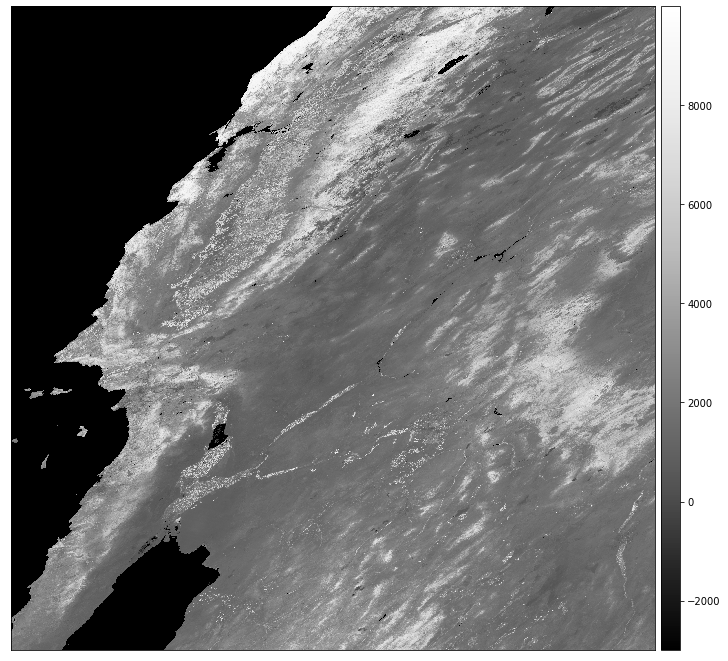

In [58]:
ep.plot_bands(vege_modis,
              scale=False)
plt.show()

In [17]:
np.savetxt("vegeData.csv", vege_modis[0], delimiter=",")